## Plot Benchmark Data
This python notebook uses `matplotlib` and `pandas`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def hist(df, local, fs, **kwargs) :
    """Get slice from pandas.DataFrame and plot histogram
    
    Histogram is filled with time / size * 10 ** 6 so that the
    filled variable has units of s / MB. The histogram generated
    is given a label corresponding to the inputs local and fs.
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe of data read in during runs
    local : bool
        copied to local scratch run or not?
    fs : str
        'hdfs' or 'zfs' filesystem
    kwargs : dict
        passed on to plt.hist
    """
    sl = df[(df['local'] == local) & (df['filesystem'] == fs)]
    local_str = 'remote'
    if local :
        local_str = 'local'
    plt.hist(sl['size']/sl['time']/10**6, label = f'{fs} {local_str}', histtype='step', **kwargs)
    
def comp(f, title = None, **kwargs) :
    """Generate a comparison plot from the input file
    
    Four histograms are put onto the plot using the hist
    function above - they involve all four combinations
    of the two local options (True/False) and the two filesystem
    options ('hdfs'/'zfs').
    
    Parameters
    ----------
    f : str
        Filename with data to read from
    title : str, optional
        Title to add to plot, use filename by default
    kwargs : dict
        Passed on to hist
    """
    
    df = pd.read_csv(f)
    hist(df, True , 'hdfs', ls='--', ec='steelblue', **kwargs)
    hist(df, False, 'hdfs', ls='-' , ec='steelblue', **kwargs)
    hist(df, True , 'zfs' , ls='--', ec='salmon'   , **kwargs)
    hist(df, False, 'zfs' , ls='-' , ec='salmon'   , **kwargs)
    plt.xlabel('Read Speed [MBps]',size='xx-large')
    plt.ylabel('File Count',size='xx-large')
    if title is None :
        title = f
    plt.title(title,size='xx-large')
    plt.legend()

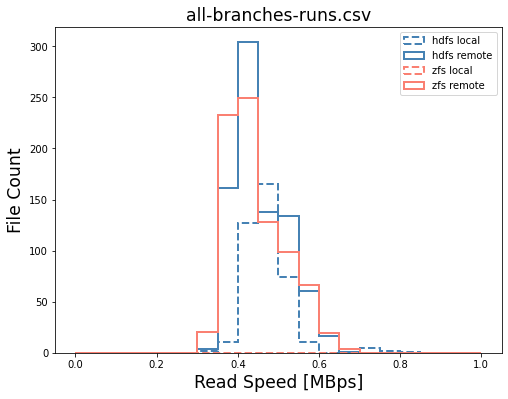

In [2]:
plt.figure(figsize=(8,6))
comp('all-branches-runs.csv',bins=20,range=(0.,1.0),lw=2.)
plt.show()